Importing all Libraries

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import re
import emoji
import string
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# ML libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Global parameters
stop_words = set(stopwords.words('indonesian'))

In [2]:
# Loading the dataset
def load_dataset(filename, cols):
    dataset = pd.read_csv(filename, encoding = 'utf-8')
    dataset.columns = cols
    return dataset

In [3]:
# Remove unwanted columns
def remove_unwanted_cols(dataset, cols):
    for col in cols:
        del dataset[col]
    return dataset

In [4]:
# Create function to process multi-word hashtags
def process_hashtag(input_text: str) -> str:
    return re.sub(
        r'#[a-zA-Z]\S*',
        lambda m: ' '.join(re.findall('[A-Z][^A-Z]*|[a-z][^A-Z]*',
                                     m.group().lstrip('#'))), input_text,
    )

In [5]:
process_hashtag('Apa #GojekAplikasiJelek')

'Apa Gojek Aplikasi Jelek'

In [6]:
# Create function to process emoji
def process_emoji(text):
    #return emoji.get_emoji_regexp().sub(r'', text)
    return emoji.replace_emoji(text, replace='')

In [7]:
process_emoji("Hi 🤔 How is your 🙈 and 😌. Have a nice weekend 💕👭👙")

'Hi  How is your  and . Have a nice weekend '

Proses Cleaning data dari Komentar di Google Play Store

In [8]:
# Create function to clean comments
def process_comment(comment):
    
    # Remove URLs
    comment = re.sub(r"http\S+|www\S+|https\S+", '', comment, flags = re.MULTILINE)
    # Remove user @ references
    comment = re.sub(r"\@\w+", '', comment)
    # Process hashtag
    comment = process_hashtag(comment)
    # Remove 1-length character
    comment = re.sub(r"\b\w{1}\b", '', comment)
    # Process emoji
    comment = process_emoji(comment)
    # Remove punctuations
    comment = comment.translate(str.maketrans('', '', string.punctuation))
    # Remove additional white spaces
    comment = re.sub(r"[\s]+", ' ', comment)
    # Remove abbreviations
    comment = re.sub(r"\b([b-df-hj-np-tv-z]){2,}\b|\b(amp)\b", '', comment)
    # Trim
    comment = comment.strip('\'"')
    # Remove duplicate consecutive words
    comment = re.sub(r"\b(\w+)\s\1\b", r"\1", comment)
    # Make lowercase
    comment = comment.lower()
    # Remove stopwords
    comment_tokens = word_tokenize(comment)  
    filtered_words = [w for w in comment_tokens if not w in stop_words]
    
    return " ".join(filtered_words)

In [9]:
def get_feature_vector(train_fit):
    vector = TfidfVectorizer(sublinear_tf = True)
    vector.fit(train_fit)
    return vector

In [10]:
def int_to_string(target):
    if target == 0:
        return "Negative"
    else:
        return "Positive"

Import data dari CSV

In [11]:
# Load the dataset
# dataset = load_dataset('data/DataGojekUse.csv', ['content','score', 'value'])


df = pd.read_csv('D:/Coding/python/DataScience/data/DataGojekUse1.csv', sep=';', encoding='latin1', on_bad_lines='skip')

# Remove unwanted column from dataset
# df = remove_unwanted_cols(dataset, ['content', 'score', 'value'])

df.head()

,content,score,value,target
0,"Smuanya lancar jaya no kenadala , is the best ...",5,POSITIF,1
1,"Membantu memenuhi kebutuhan hidup, semua jadi ...",5,POSITIF,1
2,"Halo, saya mengalami masalah dengan aplikasi g...",5,POSITIF,1
3,Ini kenapa ya... Setiap mau buka aplikasi goje...,5,POSITIF,1
4,"Semakin kesini menyusahkan pelanggan, akun lam...",5,POSITIF,1


In [12]:
# Process data
nltk.download('punkt')
df['content'] = df['content'].apply(process_comment)
df['content'][72]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'gopaylater muncul anak sultan tolong diperbaiki terima kasih'

In [13]:
# Separate positive and negative tweets
df_0 = df[df['target'] == 0]
df_1 = df[df['target'] == 1]

print('Number of NEGATIVE tweets : ', len(df_0))
print('Number of POSITIVE tweets   : ', len(df_1))

Number of NEGATIVE tweets :  1741
Number of POSITIVE tweets   :  2339


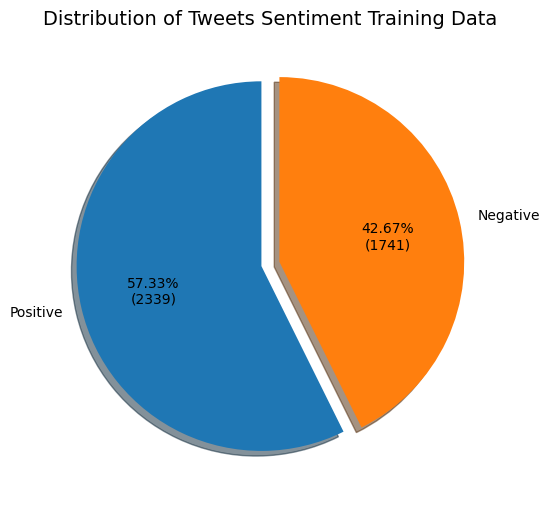

In [14]:
# Pie chart distribution of positive and negative tweets
def my_fmt(x):
    #print(x)
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)

values = pd.Series(df['target'])
v_counts = values.value_counts()
total = len(values)
labs = ['Positive', 'Negative']

pie, ax_pie = plt.subplots(figsize = [10, 6])
plt.pie(v_counts, labels = labs, autopct = my_fmt,
        shadow=True, startangle=90, explode = [0.05, 0.05])
plt.title("Distribution of Tweets Sentiment Training Data", fontsize = 14)
plt.show()

Tampilan Word Cloud

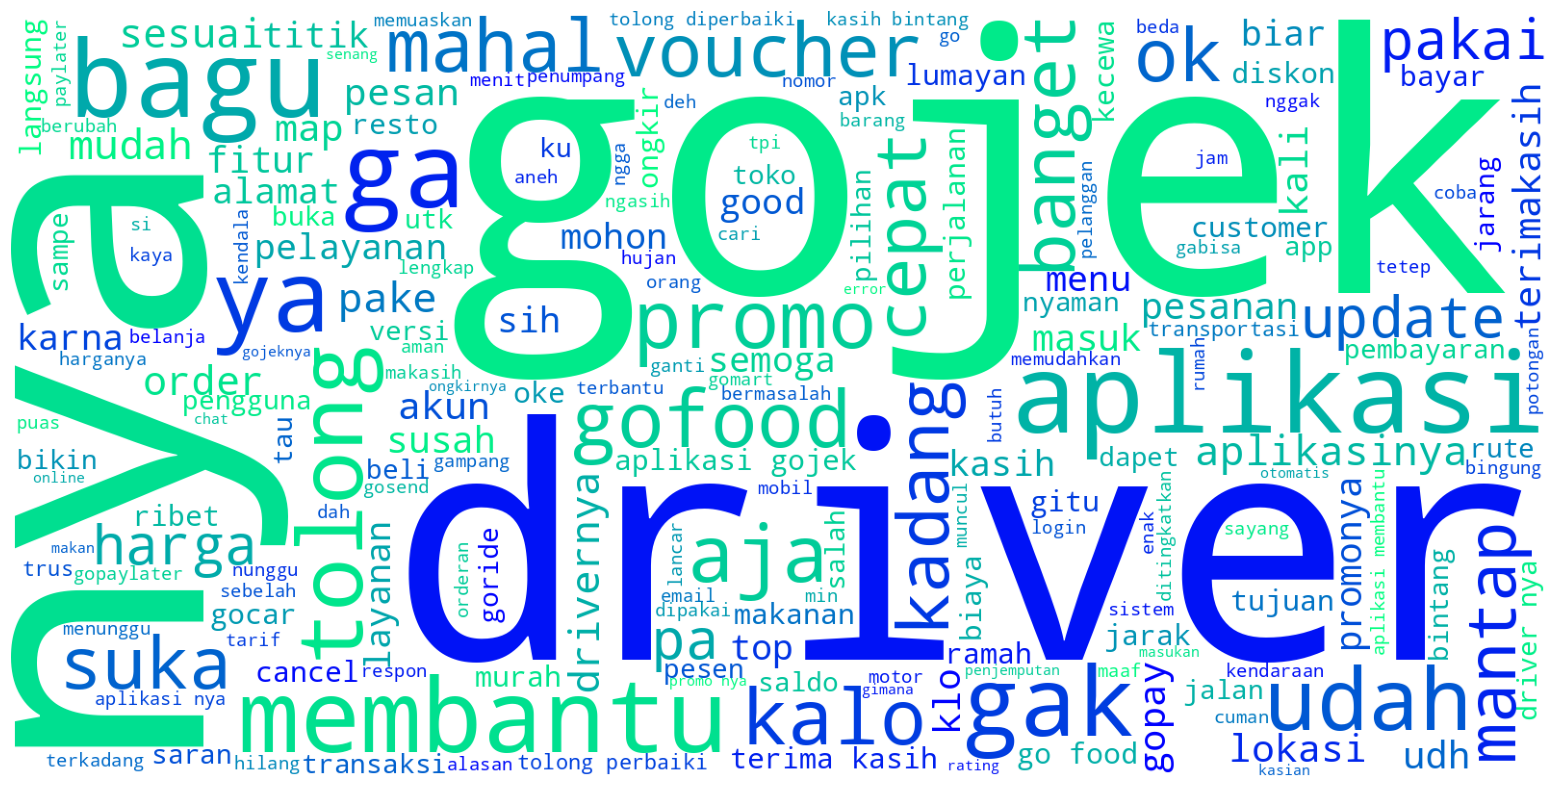

In [15]:
# Wordcloud positive
wordcloud_positive = WordCloud(background_color = "white", width = 1600, colormap='winter',
                               height = 800).generate(' '.join(df_1['content'].tolist()))
plt.figure(figsize = (20, 10), facecolor = 'w')
plt.imshow(wordcloud_positive)
plt.axis("off")
plt.show()

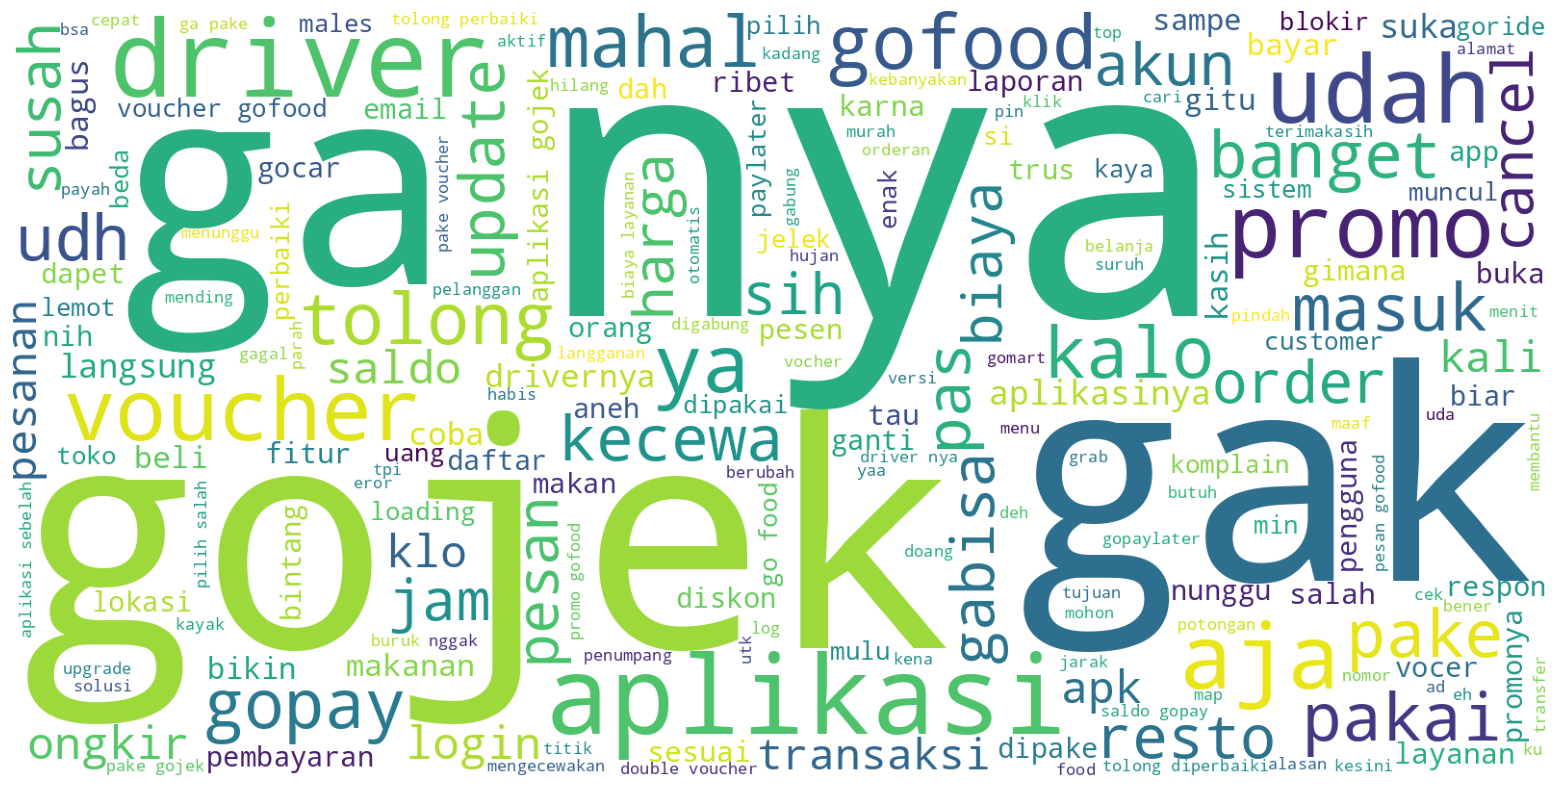

In [16]:
# Wordcloud negative
wordcloud_negative = WordCloud(background_color = "white", width = 1600,
                               height = 800).generate(' '.join(df_0['content'].tolist()))
plt.figure(figsize = (20, 10), facecolor = 'w')
plt.imshow(wordcloud_negative)
plt.axis("off")
plt.show()

Metode Analisis menggunakan Naive Bayes

In [17]:
# Split the dataset into train and test data
# Same tf vector will be used for testing sentiment on unseen trending data
tf_vector = get_feature_vector(np.array(df.iloc[:, 0]).ravel())


X = tf_vector.transform(np.array(df.iloc[:, 0]).ravel())
y = np.array(df.iloc[:, 3]).ravel()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 30)

In [18]:
# Training Naive Bayes Model
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
y_predict_nb = NB_model.predict(X_test)

print("Accuracy score: ", accuracy_score(y_test, y_predict_nb))

Accuracy score:  0.741421568627451


In [19]:
# Precision, Recall, and F1-Score Report
print(classification_report(y_test, y_predict_nb, digits = 4,
                           target_names = ['Negative', 'Positive'], zero_division=0))

              precision    recall  f1-score   support

    Negative     0.7450    0.6267    0.6808       359
    Positive     0.7393    0.8315    0.7827       457

    accuracy                         0.7414       816
   macro avg     0.7422    0.7291    0.7317       816
weighted avg     0.7418    0.7414    0.7379       816



Tampilan Confusion Metrics

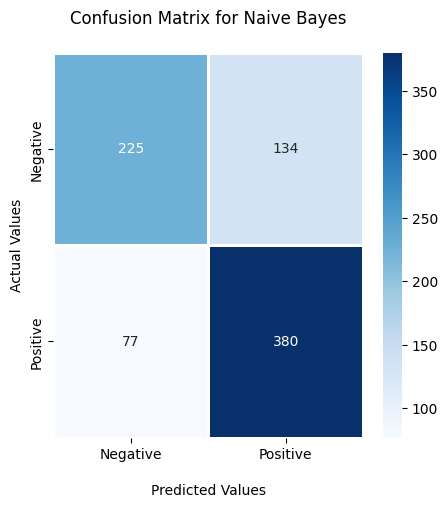

In [20]:
# Confusion metrics NB
NB_cm = confusion_matrix(y_test, y_predict_nb)

plt.figure(figsize = (5, 5))
NB_ax = sns.heatmap(NB_cm, cmap = 'Blues',
                    linecolor = 'white',
                    linewidth = 1,
                    annot = True,
                    fmt = '',
                    xticklabels = ['Negative', 'Positive'],
                    yticklabels = ['Negative', 'Positive'])
NB_ax.set_title("Confusion Matrix for Naive Bayes\n")
NB_ax.set_xlabel("\nPredicted Values")
NB_ax.set_ylabel("Actual Values")
plt.show()